In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pip install transformers
!pip install torch



In [ ]:
from collections import Counter
import re

def derive_theme(descriptions):

    all_text = ' '.join(descriptions)

    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', all_text).lower()

    words = cleaned_text.split()

    word_counts = Counter(words)

    most_common_words = word_counts.most_common(5)

    theme_words = [word for word, _ in most_common_words]

    theme = ', '.join(theme_words)

    return theme


In [ ]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

csv_file_path = '/content/gdrive/MyDrive/Customer Segmentation Project/DATA/DATSET_CUSTOMER_SEGMENTATION.csv'
data = pd.read_csv(csv_file_path)
data.dropna(axis=0, subset=['CustomerID'], inplace=True)
data_unique = data['Description'].unique()

product_descriptions = data_unique.tolist()

encoded_inputs = tokenizer(product_descriptions, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    model_outputs = model(**encoded_inputs)

bert_embeddings = model_outputs.logits.numpy()

document_embeddings = [" ".join(embedding.astype(str)) for embedding in bert_embeddings]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(document_embeddings)

k = 10
lda = LatentDirichletAllocation(n_components=k, random_state=42)
lda.fit(tfidf_matrix)

cluster_labels = lda.transform(tfidf_matrix).argmax(axis=1)

description_to_cluster = {desc: label for desc, label in zip(data_unique, cluster_labels)}
data['cluster_label'] = data['Description'].map(description_to_cluster)

cluster_themes = {}

for cluster_label in range(k):
    cluster_data = data[data['cluster_label'] == cluster_label]
    cluster_descriptions = cluster_data['Description']
    cluster_theme = derive_theme(cluster_descriptions)
    cluster_themes[cluster_label] = cluster_theme

data['theme'] = data['cluster_label'].map(cluster_themes)


print(data)


In [ ]:
cluster_themes = {}

for cluster_label in range(k):
    cluster_data = data[data['cluster_label'] == cluster_label]
    cluster_descriptions = cluster_data['Description']
    cluster_theme = derive_theme(cluster_descriptions)
    cluster_themes[cluster_label] = cluster_theme

for cluster_label, theme in cluster_themes.items():
    print(f"Cluster {cluster_label}: {theme}")


Cluster 0: set, bag, pink, red, retrospot
Cluster 1: set, of, cake, pink, blue
Cluster 2: set, of, bag, retrospot, red
Cluster 3: heart, vintage, red, christmas, set
Cluster 4: retrospot, red, bag, set, lunch
Cluster 5: design, of, set, bag, heart
Cluster 6: of, set, red, design, heart
Cluster 7: bag, red, heart, jumbo, white
Cluster 8: set, bag, of, design, red
Cluster 9: of, heart, bag, set, vintage


In [ ]:
cluster_frequency = data['cluster_label'].value_counts()

for cluster_label, frequency in cluster_frequency.items():
    print(f"Cluster {cluster_label}: {frequency} occurrences")

Cluster 7: 45853 occurrences
Cluster 5: 43520 occurrences
Cluster 4: 42590 occurrences
Cluster 2: 42048 occurrences
Cluster 9: 41369 occurrences
Cluster 0: 40869 occurrences
Cluster 1: 40758 occurrences
Cluster 3: 38059 occurrences
Cluster 8: 36814 occurrences
Cluster 6: 34949 occurrences


In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],infer_datetime_format=True)
data['Date']=data['InvoiceDate'].dt.strftime('%d/%m/%Y')
data['Time']=data['InvoiceDate'].dt.strftime('%H:%M')
data['Day of Week']=data['InvoiceDate'].dt.strftime('%A')
data['Month']=data['InvoiceDate'].dt.strftime('%B')
data['Sales_Total']=data['Quantity']*data['UnitPrice']
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_label,theme,Date,Time,Day of Week,Month,Sales_Total
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,9,"of, heart, bag, set, vintage",01/12/2010,08:26,Wednesday,December,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,6,"of, set, red, design, heart",01/12/2010,08:26,Wednesday,December,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,7,"bag, red, heart, jumbo, white",01/12/2010,08:26,Wednesday,December,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,"set, of, bag, retrospot, red",01/12/2010,08:26,Wednesday,December,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3,"heart, vintage, red, christmas, set",01/12/2010,08:26,Wednesday,December,20.34


In [ ]:
grouped_data = data.groupby(['Month', 'cluster_label'])['Sales_Total'].sum()

In [ ]:
print(grouped_data)

Month      cluster_label
April      0                 39323.100
           1                 36729.630
           2                 45629.610
           3                 42713.700
           4                 55131.100
                               ...    
September  5                108006.030
           6                 79721.472
           7                106321.260
           8                 76552.630
           9                 95477.110
Name: Sales_Total, Length: 120, dtype: float64


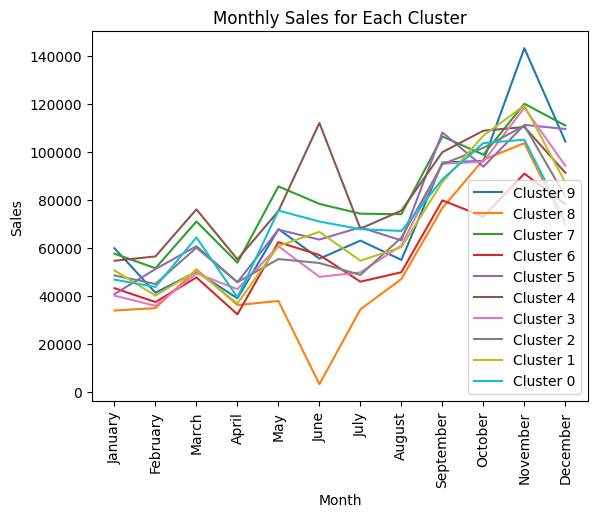

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = grouped_data.reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

grouped_data['Month'] = pd.Categorical(grouped_data['Month'], categories=month_order, ordered=True)

grouped_data = grouped_data.sort_values('Month')

clusters = grouped_data['cluster_label'].unique()

for cluster in clusters:

    cluster_data = grouped_data[grouped_data['cluster_label'] == cluster]


    plt.plot(cluster_data['Month'], cluster_data['Sales_Total'], label=f'Cluster {cluster}')


plt.title('Monthly Sales for Each Cluster')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()


plt.xticks(rotation=90)

plt.show()

In [ ]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


In [ ]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[:5])


n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders cancelled: 3654/22190 (16.47%) 


In [ ]:
columns_to_drop = ['theme', 'Date' , 'Time' , 'Day of Week' , 'Month']

data = data.drop(columns=columns_to_drop)

print(data)

        Unnamed: 0 InvoiceNo StockCode                          Description  \
0                0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1                1    536365     71053                  WHITE METAL LANTERN   
2                2    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3                3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4                4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
...            ...       ...       ...                                  ...   
541904      541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS   
541905      541905    581587     22899         CHILDREN'S APRON DOLLY GIRL    
541906      541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
541907      541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
541908      541908    581587     22138        BAKING SET 9 PIECE RETROSPOT    

        Quantity         InvoiceDate  UnitPrice  Cu

In [ ]:
display(data.sort_values('CustomerID')[:5])

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_label,Sales_Total
61619,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,6,77183.6
61624,61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,6,-77183.6
286628,286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland,7,13.5
72263,72263,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,1,12.5
72264,72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,5,12.5


In [ ]:
data_check = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1])
                & (data['Description'] == col[2])].shape[0] == 0:
        print(data_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [ ]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1])
                & (data['Description'] == col[2])].shape[0] == 0:
        print(index, data_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [ ]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) &
                         (data['InvoiceDate'] < col['InvoiceDate']) &
                         (data['Quantity']   > 0)].copy()

    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)

    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)

    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7543
doubtfull_entry: 1229


In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 56


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_label,Sales_Total,QuantityCanceled
58496,58496,C541245,85036C,ROSE 1 WICK MORRIS BOXED CANDLE,-12,2011-01-16 12:40:00,4.25,15535.0,United Kingdom,7,-51.00,0
77598,77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,5,-61.10,0
90444,90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,6,-19.80,0
111968,111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,5,-8.25,0
116064,116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,2,-24.50,0


In [ ]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_label,Sales_Total,QuantityCanceled
84247,84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,5,4.95,0
84259,84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,5,1.65,0
111968,111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,5,-8.25,0


In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_label,Sales_Total,QuantityCanceled,TotalPrice
61619,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,6,77183.60,74215,0.00
14945,14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,4,15.00,0,15.00
428987,428987,573511,23422,PANTRY HOOK BALLOON WHISK,12,2011-10-31 12:25:00,2.08,12347.0,Iceland,9,24.96,0,24.96
428988,428988,573511,23420,PANTRY HOOK TEA STRAINER,12,2011-10-31 12:25:00,2.08,12347.0,Iceland,0,24.96,0,24.96
428989,428989,573511,22699,ROSES REGENCY TEACUP AND SAUCER,18,2011-10-31 12:25:00,2.95,12347.0,Iceland,9,53.10,0,53.10


In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})


df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000000000


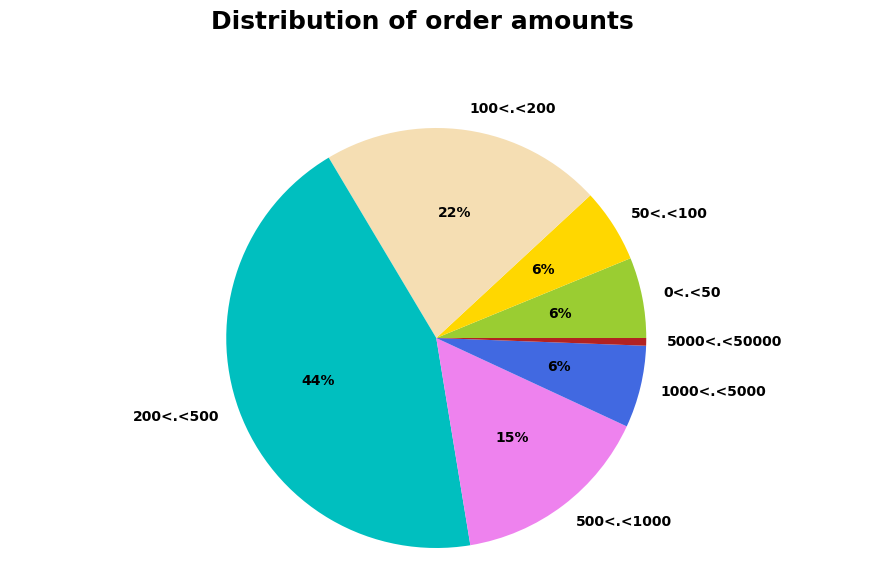

In [ ]:

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)


plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

Customer catagory

In [ ]:
product = data['Description'].unique()

In [ ]:
data[['InvoiceNo' , 'Description' , 'cluster_label']][:10]

,InvoiceNo,Description,cluster_label
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,9
1,536365,WHITE METAL LANTERN,6
2,536365,CREAM CUPID HEARTS COAT HANGER,7
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3
5,536365,SET 7 BABUSHKA NESTING BOXES,9
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,9
7,536366,HAND WARMER UNION JACK,7
8,536366,HAND WARMER RED POLKA DOT,0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4


In [ ]:
for i in range(10):
    col = 'categ_{}'.format(i)
    df_temp = data[data['cluster_label'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_cleaned['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    data.loc[:, col] = price_temp
    data[col].fillna(0, inplace = True)


data[['InvoiceNo', 'Description',
            'cluster_label', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4','categ_5','categ_6','categ_7','categ_8','categ_9']][:10]

,InvoiceNo,Description,cluster_label,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,9,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,15.3
1,536365,WHITE METAL LANTERN,6,0.0,0.0,0.00,0.00,0.00,0.0,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,7,0.0,0.0,0.00,0.00,0.00,0.0,0.00,22.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.0,0.0,20.34,0.00,0.00,0.0,0.00,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.0,0.00,20.34,0.00,0.0,0.00,0.0,0.0,0.0
5,536365,SET 7 BABUSHKA NESTING BOXES,9,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,15.3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,9,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,25.5
7,536366,HAND WARMER UNION JACK,7,0.0,0.0,0.00,0.00,0.00,0.0,0.00,11.1,0.0,0.0
8,536366,HAND WARMER RED POLKA DOT,0,11.1,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4,0.0,0.0,0.00,0.00,54.08,0.0,0.00,0.0,0.0,0.0


In [ ]:

temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Sales_Total'].sum()
basket_price = temp.rename(columns={'Sales_Total': 'Basket Price'})


for i in range(10):
    col = 'categ_{}'.format(i)
    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price[col] = temp[col]


data['InvoiceDate_int'] = data['InvoiceDate'].astype('int64')
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
data.drop('InvoiceDate_int', axis=1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])


basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,InvoiceDate
0,12346.0,541431,77183.60,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,2011-01-18 10:01:00.000000000
2,12347.0,537626,711.79,0.00,17.40,45.0,73.2,44.85,110.3,37.5,151.64,103.5,128.4,2010-12-07 14:57:00.000000000
3,12347.0,542237,475.39,21.34,67.00,43.2,48.0,53.25,55.2,27.9,44.60,59.1,55.8,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,259.80,52.70,17.0,105.9,64.95,17.0,23.4,17.00,19.8,58.7,2011-04-07 10:43:00.000000000
5,12347.0,556201,382.52,77.80,24.96,15.0,10.2,33.06,17.0,40.2,60.60,0.0,103.7,2011-06-09 13:01:00.000000000


In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
import datetime

set_entrainement = basket_price[basket_price['InvoiceDate'].dt.date < datetime.date(2011, 10, 1)]
set_test = basket_price[basket_price['InvoiceDate'].dt.date >= datetime.date(2011, 10, 1)]
basket_price = set_entrainement.copy(deep=True)


In [ ]:

transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
for i in range(10):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12347.0,5,382.52,711.79,558.172000,2790.86,13.631640,7.945938,5.754499,9.577693,12.996711,9.176383,5.095204,11.370689,7.008592,17.442652
2,12348.0,4,227.44,892.80,449.310000,1797.24,8.546438,3.538759,15.557188,11.375220,4.647126,3.538759,18.503928,24.677839,2.203379,7.411364
3,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,17.045455,18.122010,0.000000,17.613636,11.214115,0.000000,11.961722,12.021531,12.021531
4,12352.0,7,120.33,840.30,313.472857,2194.31,6.778896,5.566670,5.717059,5.873372,5.079045,8.945865,4.108353,12.792176,38.971248,0.683586


In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]


,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,LastPurchase,FirstPurchase
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255,255
1,12347.0,5,382.52,711.79,558.172000,2790.86,13.631640,7.945938,5.754499,9.577693,12.996711,9.176383,5.095204,11.370689,7.008592,17.442652,59,297
2,12348.0,4,227.44,892.80,449.310000,1797.24,8.546438,3.538759,15.557188,11.375220,4.647126,3.538759,18.503928,24.677839,2.203379,7.411364,5,288
3,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,17.045455,18.122010,0.000000,17.613636,11.214115,0.000000,11.961722,12.021531,12.021531,240,240
4,12352.0,7,120.33,840.30,313.472857,2194.31,6.778896,5.566670,5.717059,5.873372,5.079045,8.945865,4.108353,12.792176,38.971248,0.683586,2,226


In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1445/3616  (39.96%)


In [ ]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9']

selected_customers = transactions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.64159292 284.52574447 599.99406056 407.96256146   9.82168144
   9.72087748   9.50287279   8.97834577  10.88666994  10.06472433
   8.4980875   12.00696811   8.35395005  10.16676721]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

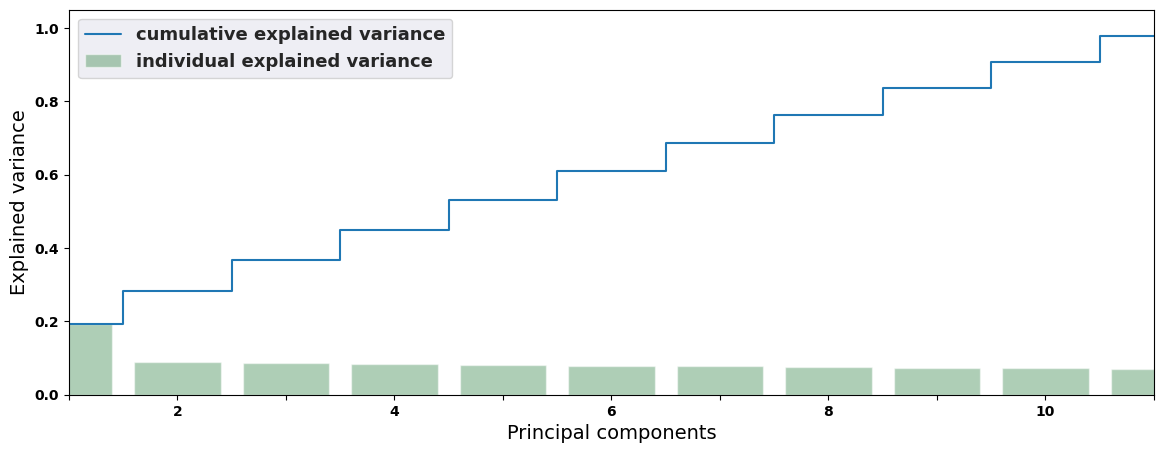

In [ ]:
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1, matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color='g',
            label='individual explained variance')

plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.235


In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,6,3,8,4,0,5,1,9,7,10,2
number of clients,2402,272,176,165,142,122,122,120,67,27,1


In [ ]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

<ipython-input-53-f52f2c7204c7>:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


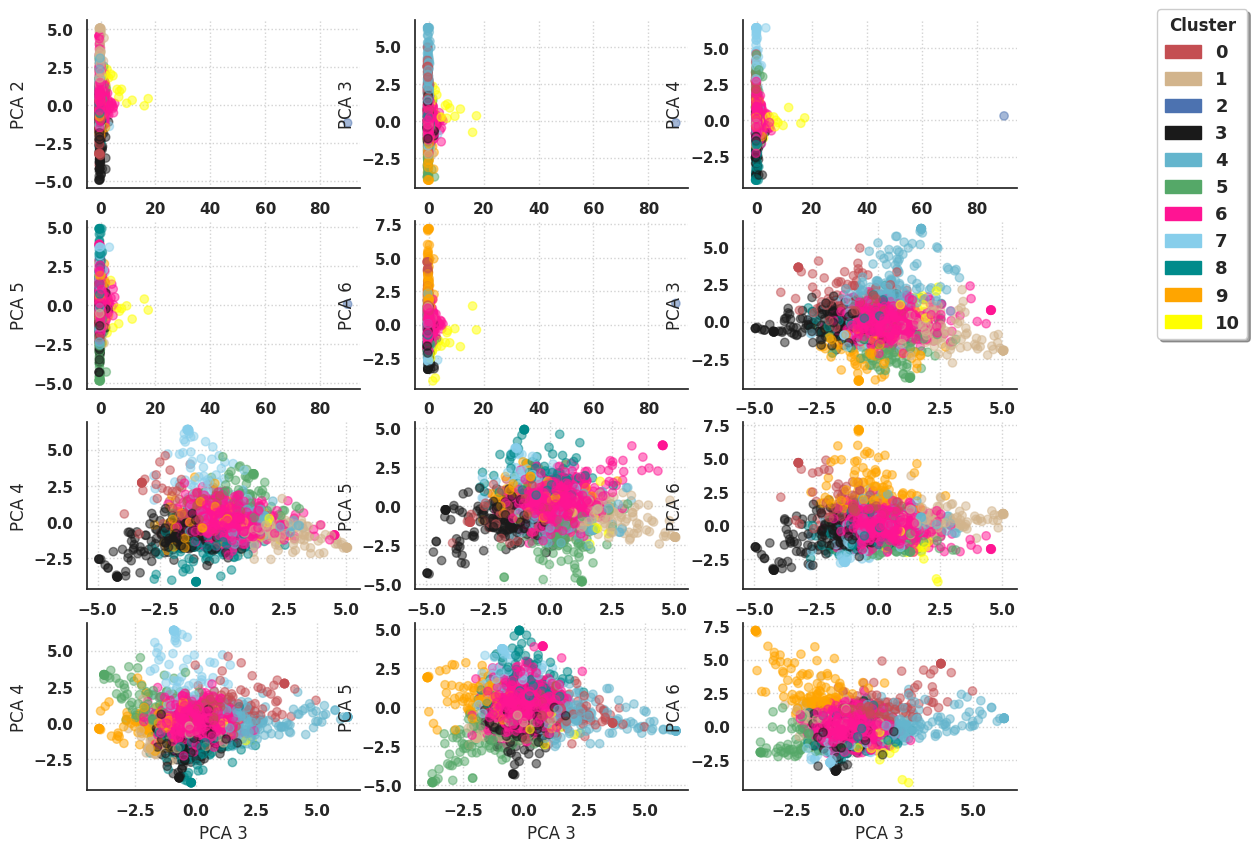

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break


comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

In [ ]:
import matplotlib as mpl

def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):

    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):


        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)


        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))


        y_lower = y_upper + 10

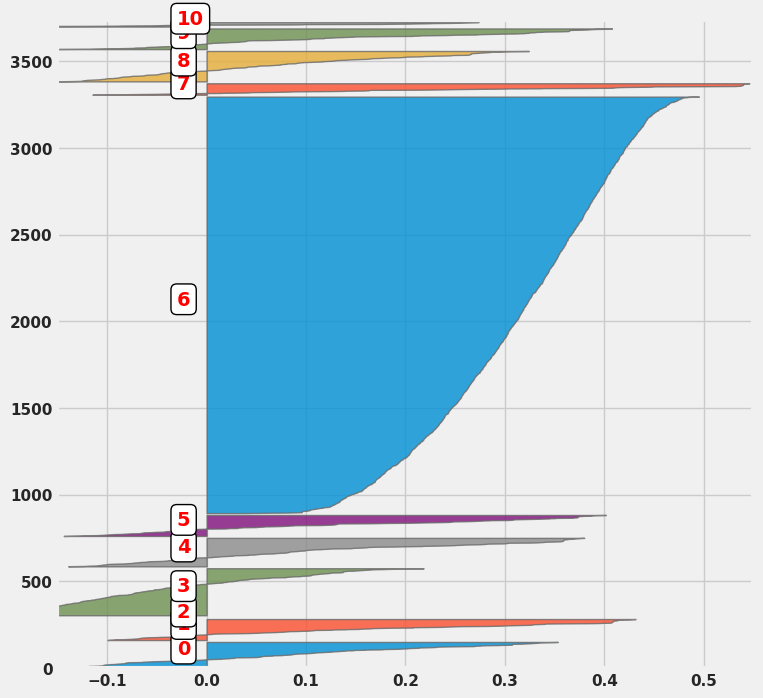

In [ ]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values,
                           clusters_clients)

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [ ]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3616


In [ ]:
liste_index = []
for j in range(10):
    column = 'categ_{}'.format(j)
    selected_rows = merged_df[merged_df[column] > 45]
    if not selected_rows.empty:
        liste_index.append(selected_rows.index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9','size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,size
0,9.0,2.050000,243.780167,353.448833,291.625149,566.177750,5.277186,46.272603,5.305171,5.260442,7.210235,6.017735,6.111822,5.492517,5.460759,6.854440,120
1,1.0,2.262295,229.895082,340.130902,279.130223,648.223607,8.062902,6.122569,4.887812,3.822792,50.979552,3.505621,3.567493,8.159036,4.060014,5.697037,122
2,7.0,1.805970,200.449552,365.692388,285.218799,593.546866,3.391403,3.618892,3.272391,3.258834,3.741509,63.890910,4.738626,3.587563,3.939571,4.516772,67
3,4.0,2.296970,220.924485,365.480000,281.348044,731.799636,7.099834,5.100547,5.070852,5.844365,6.413104,4.556603,6.199293,47.184297,5.239935,5.432176,165
4,5.0,2.098361,209.388033,306.055410,257.119624,594.359426,6.499072,5.571644,4.353273,6.829945,6.966226,6.699829,3.683761,6.584786,3.943124,47.683730,122
5,8.0,1.710227,222.396136,319.661364,267.902468,512.831477,7.479831,7.282748,35.870513,6.872431,6.749582,5.901065,5.660735,9.135898,6.532861,6.962413,176
6,0.0,2.246479,176.712324,270.249225,222.473873,524.177183,6.494458,5.786749,5.738310,6.586384,7.616122,7.200364,38.830884,9.180062,5.114277,6.174802,142
7,3.0,2.437500,249.853493,412.350846,320.116127,883.324559,4.863292,6.836555,6.419499,21.857469,6.968655,5.467154,6.929292,7.385033,24.224106,6.901869,272
8,6.0,3.860949,282.164934,592.640917,415.624973,1577.357445,11.610139,9.533687,9.340030,8.765330,10.667170,10.655791,7.982064,11.529227,7.827303,9.984922,2402
9,10.0,49.333333,332.499259,9482.297778,2515.353322,57076.886667,9.542485,8.306986,8.648472,7.695558,12.418890,9.296511,7.506719,11.857528,6.722972,9.844985,27


Prediction Model

In [ ]:
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.metrics import confusion_matrix
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [ ]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,LastPurchase,FirstPurchase
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255,255
1,12347.0,5,382.52,711.79,558.172000,2790.86,13.631640,7.945938,5.754499,9.577693,12.996711,9.176383,5.095204,11.370689,7.008592,17.442652,59,297
2,12348.0,4,227.44,892.80,449.310000,1797.24,8.546438,3.538759,15.557188,11.375220,4.647126,3.538759,18.503928,24.677839,2.203379,7.411364,5,288
3,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,17.045455,18.122010,0.000000,17.613636,11.214115,0.000000,11.961722,12.021531,12.021531,240,240
4,12352.0,7,120.33,840.30,313.472857,2194.31,6.778896,5.566670,5.717059,5.873372,5.079045,8.945865,4.108353,12.792176,38.971248,0.683586,2,226


In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)

Precision: 87.57 % 


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 87.57 % 


In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


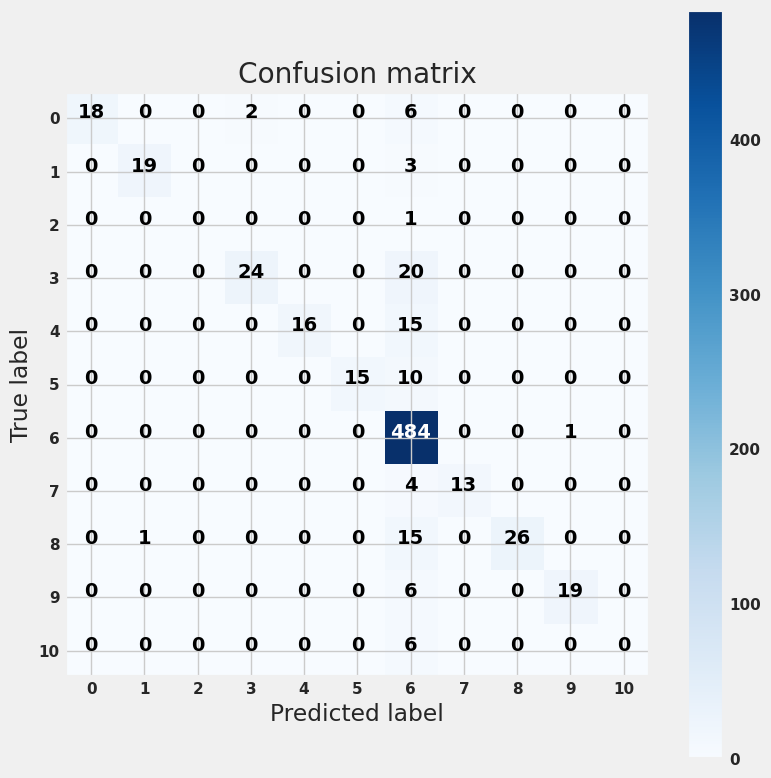

In [ ]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

Learning curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

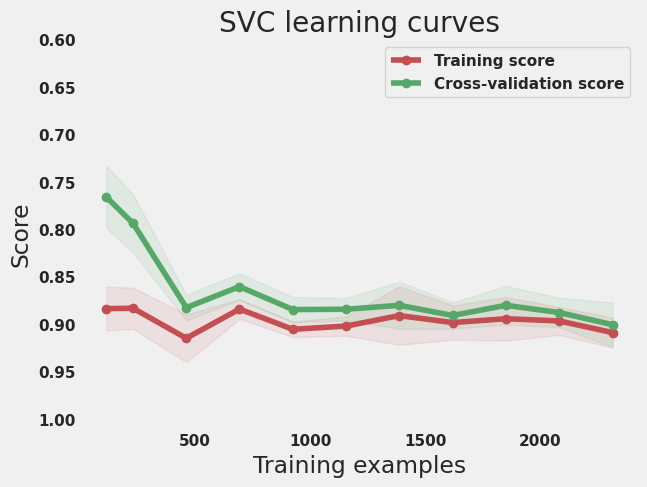

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

Logistic Regression

In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

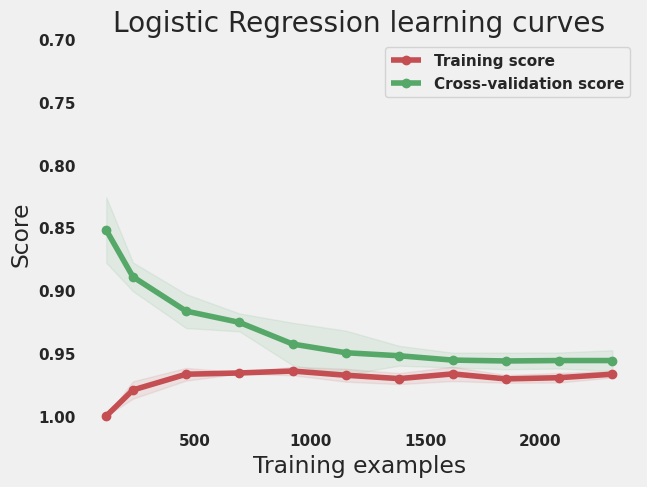

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

KNN

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 80.52 % 


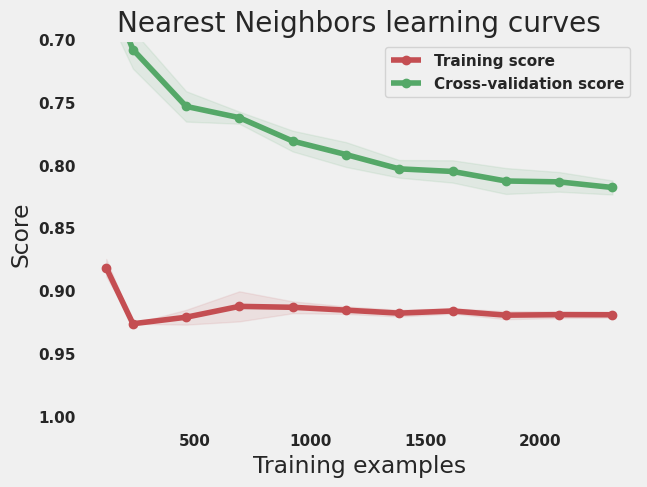

In [ ]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Decision Tree

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 87.57 % 


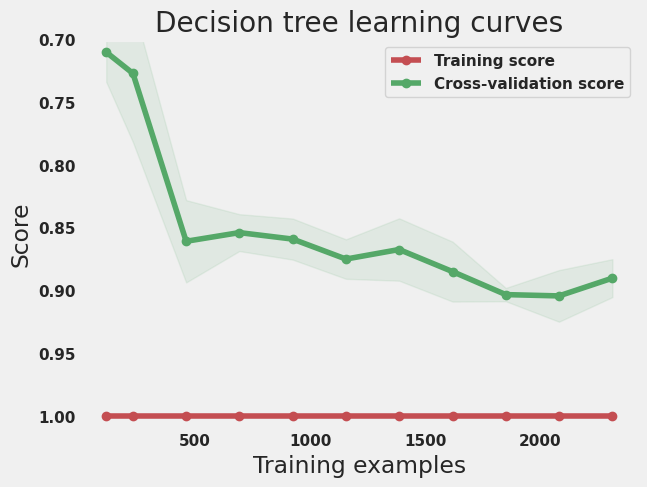

In [ ]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Random Forest

In [ ]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 95.03 % 


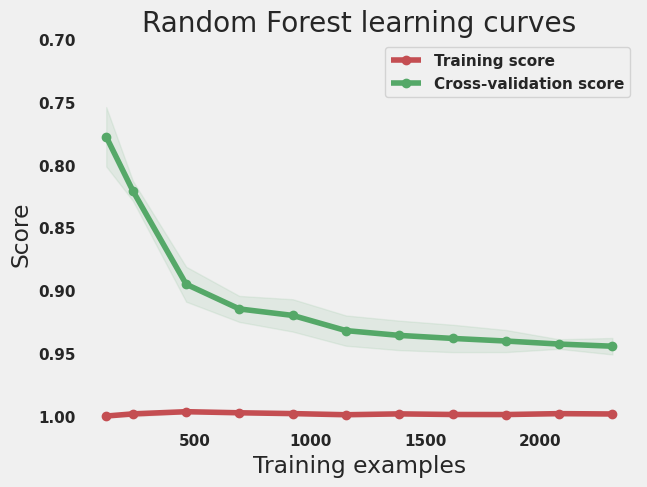

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 76.52 % 


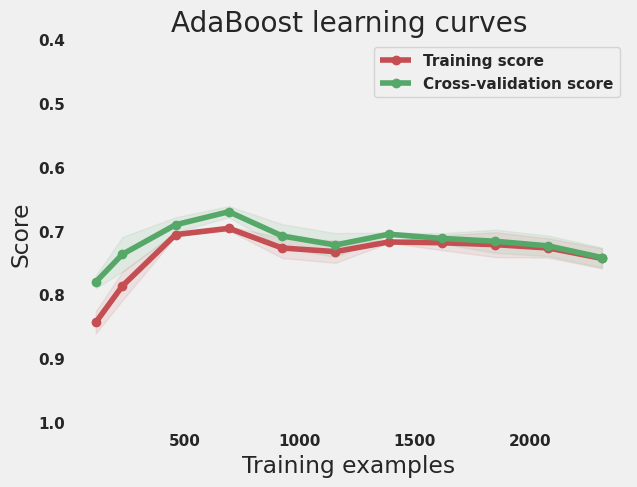

In [ ]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Gradient boost Clasifier

In [ ]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 95.17 % 


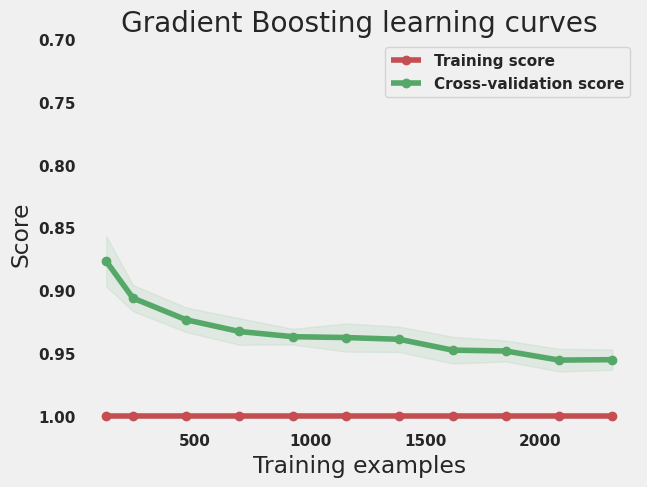

In [ ]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Find Best approach

In [ ]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [ ]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [ ]:
votingC = votingC.fit(X_train, Y_train)

In [ ]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 94.48 % 


In [ ]:
basket_price = set_test.copy(deep = True)

In [ ]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(10):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9
0,12347.0,10,224.82,1294.32,759.57,7595.70,7.067156,15.631212,8.281001,10.584936,12.999460,3.107021,3.954869,7.069789,6.556341,24.748213
1,12349.0,5,1757.55,1757.55,1757.55,8787.75,10.394014,6.023157,11.035248,4.892037,2.443743,8.804301,11.956986,25.733550,12.392820,6.324144
2,12352.0,5,311.73,311.73,311.73,1558.65,6.383730,16.546370,15.333782,7.217785,5.453437,0.000000,6.351650,25.663234,0.000000,17.050011
3,12356.0,5,58.35,58.35,58.35,291.75,0.000000,0.000000,0.000000,0.000000,43.701799,0.000000,0.000000,0.000000,0.000000,56.298201
4,12357.0,5,6207.67,6207.67,6207.67,31038.35,7.429196,5.176822,13.804213,12.482944,8.558767,13.492663,13.091546,9.385808,5.985660,10.592380


In [ ]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9']


matrix_test = transactions_per_user[list_cols].values


scaled_test_matrix = scaler.transform(matrix_test)


In [ ]:
Y = kmeans.predict(scaled_test_matrix)

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9' ]
X = transactions_per_user[columns]

In [ ]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 85.31 % 
______________________________ 
Logostic Regression
Precision: 92.62 % 
______________________________ 
k-Nearest Neighbors
Precision: 78.52 % 
______________________________ 
Decision Tree
Precision: 82.58 % 
______________________________ 
Random Forest
Precision: 91.41 % 
______________________________ 
Gradient Boosting
Precision: 91.56 % 


In [ ]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 91.68 % 
